In [1]:
import pandas as pd
import numpy as np

In [2]:
file_url = 'https://raw.githubusercontent.com/AGilarde12/Mall-Customer-Segmentation/master/Data/Mall_Customers.csv'

In [3]:
df = pd.read_csv(file_url)

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df_cleaned = df.copy()
df_cleaned.drop('CustomerID', axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test = train_test_split(df_cleaned, test_size=0.2, random_state=8)

In [9]:
X_train_cleaned = X_train.copy()
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
sc = StandardScaler()
X_train_cleaned[num_cols] = sc.fit_transform(X_train_cleaned[num_cols])

In [10]:
cat_cols = ['Gender']
ohe = OneHotEncoder(sparse=False, drop='first')
X_train_cleaned[cat_cols]=ohe.fit_transform(X_train_cleaned[cat_cols])

In [11]:
X_train_cleaned.reset_index(drop=True, inplace=True)
X_train_cleaned.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,1.771416,-0.844380,-0.585705
1,0.0,-0.583546,-1.674190,-0.388498
2,0.0,0.386144,2.632916,-0.861795
3,0.0,-1.414709,0.143488,0.163682
4,1.0,-0.514282,0.617665,1.701898


In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [13]:
model = KElbowVisualizer(KMeans(), k=(2,35))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1c0506c50>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=34,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

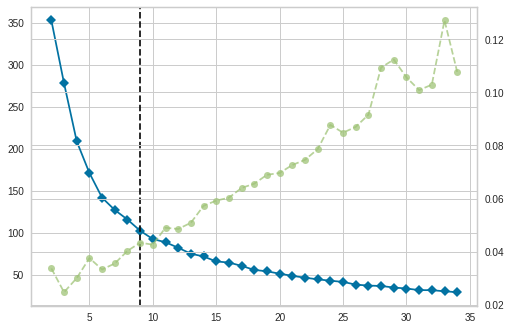

In [14]:
model.fit(X_train_cleaned)

In [15]:
n_clusters = model.elbow_value_
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_clusters, random_state=8)
gmm.fit(X_train_cleaned)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=9, n_init=1, precisions_init=None,
                random_state=8, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [16]:
gmm.predict(X_train_cleaned)

array([4, 7, 7, 7, 3, 8, 7, 7, 7, 5, 3, 0, 8, 7, 0, 6, 5, 7, 6, 7, 7, 1,
       5, 7, 7, 4, 7, 7, 5, 7, 3, 3, 7, 7, 7, 7, 7, 7, 7, 4, 7, 6, 3, 4,
       0, 7, 2, 8, 8, 2, 6, 0, 5, 7, 7, 7, 7, 7, 7, 5, 8, 4, 8, 3, 7, 1,
       1, 3, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 8, 4, 8, 7, 5, 7, 7, 7, 7, 8,
       7, 7, 8, 7, 4, 1, 8, 7, 5, 7, 5, 7, 7, 7, 8, 8, 1, 3, 7, 7, 7, 8,
       8, 7, 7, 8, 8, 7, 4, 4, 8, 8, 8, 8, 7, 8, 7, 7, 7, 3, 3, 5, 8, 8,
       7, 3, 0, 6, 8, 8, 8, 7, 7, 8, 3, 7, 8, 7, 7, 3, 0, 8, 0, 7, 7, 8,
       5, 7, 7, 7, 7, 7])

In [17]:
obs = pd.DataFrame(X_train_cleaned.iloc[17]).transpose()
gmm.predict(obs)
obs.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
17,0.0,-0.514282,0.696694,0.952511


In [18]:
from sklearn.pipeline import Pipeline

In [19]:
num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

In [20]:
cat_transformer = Pipeline(
    steps=[
        ('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'))
    ]
)

In [21]:
from sklearn.compose import ColumnTransformer

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_cols', num_transformer, num_cols),
        ('cat_cols', cat_transformer, cat_cols)
    ]
)

In [23]:
gmm_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('clustering', GaussianMixture(n_components=6, random_state=8))
    ]
)

In [24]:
gmm_pipe.fit(X_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_cols',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                         

In [25]:
obs = pd.DataFrame(X_train.iloc[8]).transpose()
gmm_pipe.predict(obs)
obs.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
94,Female,32,60,42


In [26]:
from joblib import dump 

dump(gmm_pipe,  '../models/gmm_pipeline.joblib')

['../models/gmm_pipeline.joblib']